# Data Science - Module 1 - Final Project Submission

* Student Name: **James Toop**
* Student Pace: **Self Paced**
* Scheduled project review date/time: **10th September 2020 - 3pm GMT**
* Instructor name: **Jeff Herman**
* Blog post URL: **TBC**

## Exploratory Data Analysis (EDA)

This notebook presents a more detailed investigation of the data, exploring a number of themes to aide business decision making, specifically:

1. [What is the size of the opportunity to the business? i.e. why we should venture into the film industry in the first place](#q1) 
2. [What is the potential return (and risk) on the investment? i.e. show the profitability of film.](#q2)
3. [Is there a relationship between production budget, box office takings and profit? i.e. if you spend more do you make more](#q3)
4. [What types of films "perform" better than others?](#q4) Performance will have to be measured by ratings and Gross Income (box office takings) as we don't have the data to measure performance on Net Income.
5. Is there a relationship between ratings and box office takings? i.e. Does a film with lower ratings also fail at the box office?


* Which studios have been producing the most films?
* Number of films by genre
* Number of films by year and by genre


In [149]:
# Import the relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

---

<a name="q1"></a>
### 1. What is the size of the opportunity to the business? 

Why we should venture into the film industry when the market is already crowded.

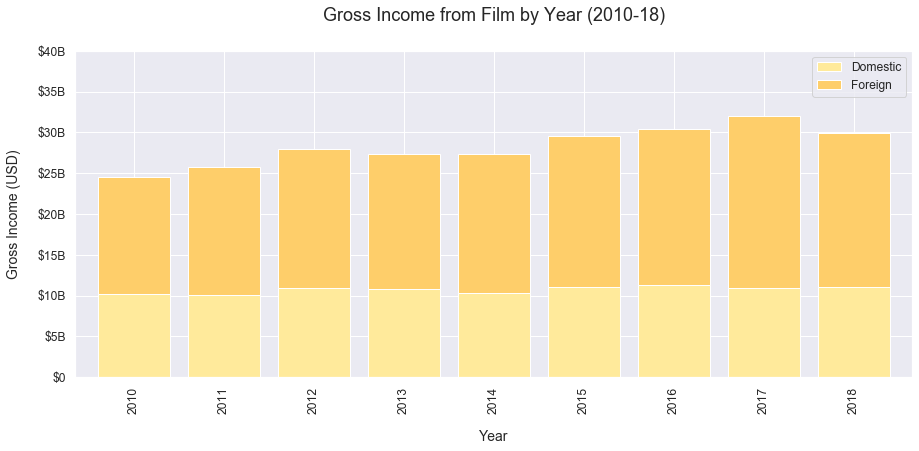

In [169]:
# Import the Box Office Mojo data

df_bom = pd.read_csv('zippedData/bom.movie_gross.csv.gz', compression='gzip', header=0, thousands=",")


# Handle missing values and datatypes to aide analysis

df_bom[['domestic_gross', 'foreign_gross']] = df_bom[['domestic_gross', 'foreign_gross']].fillna(0).astype(int)
df_bom[['year']] = df_bom[['year']].astype(str)


# Handle the incorrect foreign gross income data, out by a factor of 1,000,000 for the following films:
#  - The Fate of the Furious
#  - Jurassic World
#  - Star Wars: The Force Awakens
#  - Furious 7
#  - Avengers: Infinity War

df_bom.loc[df_bom.title.isin(['The Fate of the Furious',
                              'Jurassic World',
                              'Star Wars: The Force Awakens',
                              'Furious 7',
                              'Avengers: Infinity War'
                             ]) & (df_bom.foreign_gross < 1e6), 'foreign_gross'] = df_bom['foreign_gross'] * 1e6


# Handle any potential duplicates within the dataset based on film title and studio and sort by year

df_bom = df_bom.sort_values('year').drop_duplicates(subset=['title', 'studio'])


# Creating our first plot looking at Gross Income from Film year-on-year
sns.set(font_scale=1.1)
sns.set_palette(sns.color_palette('YlOrRd'))

existing_yvalues = [0,0.5e10,1e10,1.5e10,2e10,2.5e10,3e10,3.5e10,4e10]
readable_yvalues = ['$0','$5B','$10B','$15B','$20B','$25B','$30B','$35B','$40B']
chart_data = df_bom[['year','domestic_gross','foreign_gross']].set_index('year').groupby('year').sum()
chart_data.plot(kind='bar', stacked=True, figsize=(15,6), width=0.8)
plt.ylim(0,4e10)
plt.yticks(existing_yvalues, readable_yvalues)
plt.title('Gross Income from Film by Year (2010-18)', fontsize=18, pad=30)
plt.xlabel('Year', fontsize=14, labelpad=16)
plt.ylabel('Gross Income (USD)', fontsize=14, labelpad=16)
plt.legend(['Domestic','Foreign'])

plt.show()

---

<a name="q2"></a>
### 2. What is the potential return (and risk) on the investment? 

Show the profitability of film.

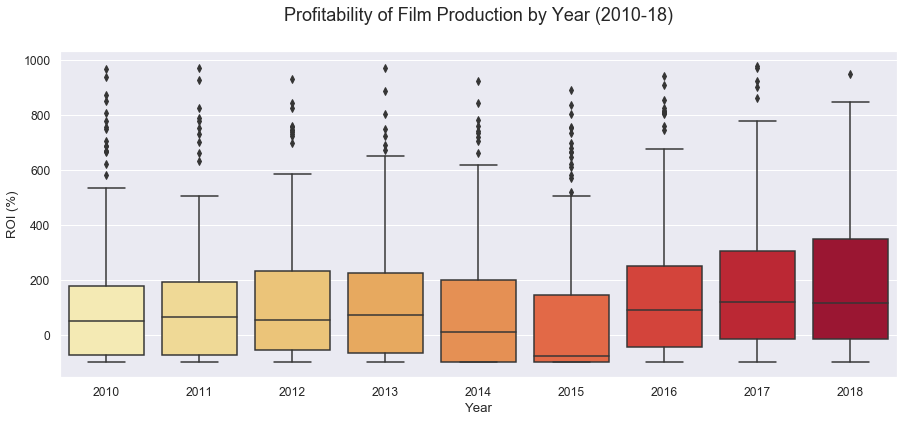

In [168]:
# Import TheNumbers - Movie Budgets dataset

df_tn_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', compression='gzip', header=0)


# Remove text and convert datatypes to aide analysis

df_tn_budgets['production_budget'] = df_tn_budgets['production_budget'].str.replace('$', '')
df_tn_budgets['production_budget'] = df_tn_budgets['production_budget'].str.replace(',', '')
df_tn_budgets['production_budget'] = df_tn_budgets['production_budget'].astype(int)
df_tn_budgets['domestic_gross'] = df_tn_budgets['domestic_gross'].str.replace('$', '')
df_tn_budgets['domestic_gross'] = df_tn_budgets['domestic_gross'].str.replace(',', '')
df_tn_budgets['domestic_gross'] = df_tn_budgets['domestic_gross'].astype(int)
df_tn_budgets['worldwide_gross'] = df_tn_budgets['worldwide_gross'].str.replace('$', '')
df_tn_budgets['worldwide_gross'] = df_tn_budgets['worldwide_gross'].str.replace(',', '')
df_tn_budgets['worldwide_gross'] = df_tn_budgets['worldwide_gross'].astype(int)


# Add additional columns to the DataFrame for Release Year and Profit Margin

df_tn_budgets.insert(2, 'release_year', df_tn_budgets['release_date'].str[-4:].astype(int))
df_tn_budgets.insert(7, 'profit', (df_tn_budgets['worldwide_gross'] - df_tn_budgets['production_budget']))
df_tn_budgets.insert(8, 'roi', ((df_tn_budgets['profit'] / df_tn_budgets['production_budget'])*100).astype(float))


# Filter the dataframes to only show data between 2010 and 2018, remove outliers and sort by release year

df_tn_budgets = df_tn_budgets[(df_tn_budgets['release_year'] >=2010) & (df_tn_budgets['release_year'] <=2018)]
df_tn_budgets = df_tn_budgets[(df_tn_budgets['roi'] <= 1000) & 
                              (df_tn_budgets['roi'] >= -100)].sort_values('release_year')


# Creating a boxplot to show profitability of the film industry since 2010

plt.figure(figsize=(15,6))
plt.title('Profitability of Film Production by Year (2010-18)', fontsize=18, pad=30)
sns.boxplot(
    x=df_tn_budgets['release_year'],
    y=df_tn_budgets['roi'], 
    data=df_tn_budgets, 
    width=0.8, 
    palette='YlOrRd').set(
    xlabel='Year', 
    ylabel='ROI (%)'
)

plt.show()


---
<a name="#q3"></a>
### 3. Is there a relationship between production budget, box office takings and profit?

If you spend more on the film do you make more.

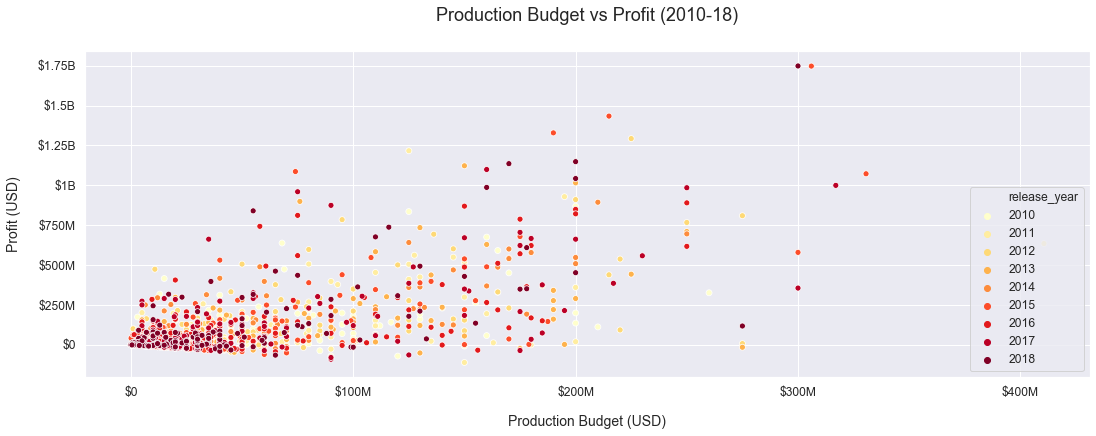

In [186]:
# Import TheNumbers - Movie Budgets dataset

df_film_profits = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', compression='gzip', header=0)


# Remove text and convert datatypes to aide analysis

df_film_profits['production_budget'] = df_film_profits['production_budget'].str.replace('$', '')
df_film_profits['production_budget'] = df_film_profits['production_budget'].str.replace(',', '')
df_film_profits['production_budget'] = df_film_profits['production_budget'].astype(int)
df_film_profits['domestic_gross'] = df_film_profits['domestic_gross'].str.replace('$', '')
df_film_profits['domestic_gross'] = df_film_profits['domestic_gross'].str.replace(',', '')
df_film_profits['domestic_gross'] = df_film_profits['domestic_gross'].astype(int)
df_film_profits['worldwide_gross'] = df_film_profits['worldwide_gross'].str.replace('$', '')
df_film_profits['worldwide_gross'] = df_film_profits['worldwide_gross'].str.replace(',', '')
df_film_profits['worldwide_gross'] = df_film_profits['worldwide_gross'].astype(int)


# Add additional columns to the DataFrame for Release Year and Profit Margin

df_film_profits.insert(2, 'release_year', df_film_profits['release_date'].str[-4:].astype(int))
df_film_profits.insert(7, 'profit', (df_film_profits['worldwide_gross'] - df_film_profits['production_budget']))


# Filter the dataframes to only show data between 2010 and 2018, remove outliers and sort by release year

df_film_profits = df_film_profits[(df_film_profits['release_year'] >=2010) 
                                & (df_film_profits['release_year'] <=2018)].sort_values('release_year')


# Creating a scatterplot to show variation of production budget against profit

existing_xvalues = [0,1e8,2e8,3e8,4e8]
existing_yvalues = [0.00,0.25e9,0.5e9,0.75e9,1.00e9,1.25e9,1.50e9,1.75e9]
readable_xvalues = ['$0','$100M','$200M','$300M','$400M']
readable_yvalues = ['$0','$250M','$500M','$750M','$1B','$1.25B','$1.5B','$1.75B']
plt.figure(figsize=(18,6))
plt.title('Production Budget vs Profit (2010-18)', fontsize=18, pad=30)
sns.scatterplot(
    x=df_film_profits['production_budget'],
    y=df_film_profits['profit'],
    hue=df_film_profits['release_year'],
    data=df_film_profits, 
    palette='YlOrRd',
    legend='full'
)
plt.legend(loc='lower right')
plt.xticks(existing_xvalues, readable_xvalues)
plt.xlabel('Production Budget (USD)', fontsize=14, labelpad=16)
plt.yticks(existing_yvalues, readable_yvalues)
plt.ylabel('Profit (USD)', fontsize=14, labelpad=16)

plt.show()

---
<a name="q4"></a>
### 4. What types / genres of films "perform" better than others?

In [192]:
# Create the database and data tables prior to importing the data

conn = sqlite3.connect('tmdb-films.db')
c = conn.cursor()


# Create [tmdb_films] table
c.execute('''CREATE TABLE tmdb_films (
[genre_ids] text,
[id] integer PRIMARY KEY,
[original_language] text,
[original_title] text,
[popularity] float,
[release_date] text,
[title] text,
[vote_average] float,
[vote_count] integer
)''')


# Create [tmdb_genres] table
c.execute('''CREATE TABLE tmdb_genres (
[genre_id] integer PRIMARY KEY,
[genre] text
)''')
          
conn.commit()


# Import TMDB dataset dropping the first, extraneous column and de-duping based on film title and ID

read_tmdb_films = pd.read_csv('zippedData/tmdb.movies.csv.gz', compression='gzip', header=0)
read_tmdb_films.drop('Unnamed: 0', axis=1, inplace=True)
read_tmdb_films.sort_values('id', inplace=True)
read_tmdb_films.drop_duplicates(subset=['id'], keep='first', inplace=True)
read_tmdb_films.to_sql('tmdb_films', conn, if_exists='append', index = False)

read_tmdb_genres = pd.read_csv('zippedData/tmdb.movie_genres.csv.gz', compression='gzip', header=0)
read_tmdb_genres.to_sql('tmdb_genres', conn, if_exists='append', index = False)

In [244]:
# Return dataframe for all films with popularity by year in a specific genre

def get_films_by_genre(genre):
    c.execute('''
    SELECT
    ? AS `genre`,
    `films`.`popularity`
    FROM `tmdb_films` `films`
    WHERE SUBSTR(`films`.`release_date`,1,4) IN ('2010','2011','2012','2013','2014','2015','2016','2017','2018')
    AND EXISTS (
    SELECT `genre_id` 
    FROM `tmdb_genres`
    WHERE `films`.`genre_ids` LIKE '%' || genre_id || '%'
    AND `genre` = ?)
    ;''', genre)
    
    df = pd.DataFrame(c.fetchall())
    df.columns = [x[0] for x in c.description]

    return df

# Load each list of films by genre into an individual dataframe.  
# This deliberately duplicates films into multiple dataframes as we're looking at genre popularity

df_action = get_films_by_genre(['Action','Action'])
df_adventure = get_films_by_genre(['Adventure','Adventure'])
df_animation = get_films_by_genre(['Animation','Animation'])
df_comedy = get_films_by_genre(['Comedy','Comedy'])
df_crime = get_films_by_genre(['Crime','Crime'])
df_documentary = get_films_by_genre(['Documentary','Documentary'])
df_drama = get_films_by_genre(['Drama','Drama'])
df_family = get_films_by_genre(['Family','Family'])
df_fantasy = get_films_by_genre(['Fantasy','Fantasy'])
df_history = get_films_by_genre(['History','History'])
df_music = get_films_by_genre(['Music','Music']) 
df_mystery = get_films_by_genre(['Mystery','Mystery'])
df_romance = get_films_by_genre(['Romance','Romance'])
df_scifi = get_films_by_genre(['Science Fiction','Science Fiction'])
df_thriller = get_films_by_genre(['Thriller','Thriller'])
df_war = get_films_by_genre(['War','War'])
df_western = get_films_by_genre(['Western','Western'])

,genre,popularity
0,Science Fiction,8.335
1,Science Fiction,25.808
2,Science Fiction,28.515
3,Science Fiction,9.419
4,Science Fiction,7.976


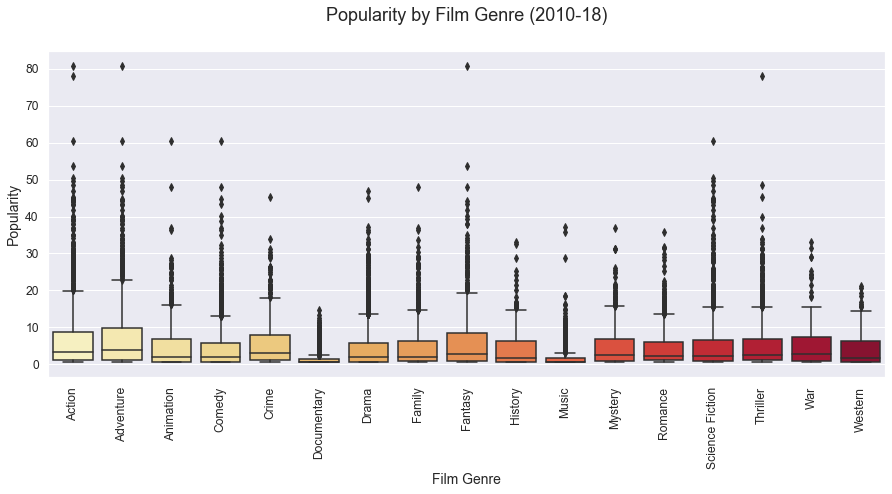

In [262]:
genres = [df_action, 
          df_adventure, 
          df_animation, 
          df_comedy, 
          df_crime,
          df_documentary,
          df_drama,
          df_family,
          df_fantasy,
          df_history,
          df_music,
          df_mystery,
          df_romance,
          df_scifi,
          df_thriller,
          df_war,
          df_western
         ]
all_genres = pd.concat(genres)

plt.figure(figsize=(15,6))
plt.title('Popularity by Film Genre (2010-18)', fontsize=18, pad=30)
chart = sns.boxplot(
    x=all_genres['genre'],
    y=all_genres['popularity'], 
    data=all_genres, 
    width=0.8, 
    palette='YlOrRd')

chart.set_xlabel('Film Genre', fontsize=14)
chart.set_ylabel('Popularity', fontsize=14)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

plt.show()